In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import numpy as np

import medmnist
from medmnist import INFO

In [5]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [9]:
data_flag = 'breastmnist' # dataset a usar
download = True # Checa si el dataset esta descargado, si no descargalo
root = '/lustre/proyectos/p032/datasets' # Ruta a datasets

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag] # JSON con info del dataset
task = info['task'] # La tarea a realizar del dataset
n_channels = info['n_channels'] # Numero de canales, creo que es input
n_classes = len(info['label']) # Cuantas clases hay que clasificar

DataClass = getattr(medmnist, info['python_class']) # Lo mismo que from medmnist import BreastMNIST

In [10]:
# Funcion para preprocesar datos
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Cargar los datasets con preprocesamiento
train_dataset = DataClass(split='train', transform=data_transform, download=download, root=root)
test_dataset = DataClass(split='test', transform=data_transform, download=download, root=root)

# Cargar datasets sin preprocesamiento
pil_dataset = DataClass(split='train', download=download, root=root)

# Cargar los datasets como datasets de PyTorch
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


In [21]:
print(train_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /lustre/proyectos/p032/datasets
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0


In [ ]:
train_dataset[0] # Esta implementado el operador de acceso

(tensor([[[ 0.0902,  0.0902,  0.0824,  0.0902,  0.1137,  0.1686,  0.2235,
            0.2471,  0.2863,  0.3098,  0.3176,  0.2784,  0.3020,  0.3255,
            0.2863,  0.3020,  0.2706,  0.2392,  0.2863,  0.2235,  0.2235,
            0.2941,  0.2627,  0.2078,  0.2235,  0.2941,  0.2706,  0.2941],
          [-0.3412, -0.2784, -0.2627, -0.3412, -0.3412, -0.3255, -0.2627,
           -0.1451,  0.0118,  0.0588,  0.0275,  0.0196,  0.0667, -0.0196,
           -0.1294, -0.0667, -0.0824, -0.0510,  0.0275, -0.0824,  0.0353,
            0.0431,  0.0431,  0.0902,  0.0980, -0.0275, -0.0902, -0.1216],
          [-0.3412, -0.3569, -0.3176, -0.2078, -0.2078, -0.2471, -0.2941,
           -0.2549, -0.1686, -0.2392, -0.3255, -0.2392, -0.0902, -0.1608,
           -0.2863, -0.3255, -0.3961, -0.2863,  0.0039,  0.0118,  0.0118,
            0.0196,  0.0667,  0.0667,  0.0039, -0.0275, -0.0039, -0.0118],
          [-0.3490, -0.3961, -0.2549, -0.0588, -0.1608, -0.4039, -0.2706,
           -0.2471, -0.1686, -0.105

In [ ]:
len(train_dataset) # Funcion len implementada

546

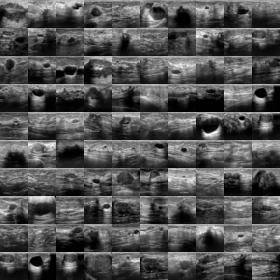

In [ ]:
train_dataset.montage(10) # Metodo para visualizar dataset

In [20]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
    print(f'GPU: {torch.cuda.get_device_name(0)}')
else:
    device = 'cpu'
    print('Se está trabajando en CPU')
    
inputs = inputs.to(device)
labels = labels.to(device)
model = model.to(device)

usando GPU
